In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
atom_pos = pd.read_csv('curved.data', header=None, sep=' ', index_col=0).iloc[:, 2:]
atom_pos.columns=['x', 'y', 'z']
com = np.mean(atom_pos, axis=0)
atom_pos.head()

,x,y,z
0,,,
1,0.0,1.0,2.5
4,1.0,2.0,2.5
7,2.0,2.5,2.5
10,3.0,2.0,2.5
13,4.0,1.0,2.5


In [3]:
bond_l = np.sqrt((atom_pos['x'].diff()**2) + (atom_pos['y'].diff()**2) + (atom_pos['z'].diff()**2)).values
r1 = bond_l[1]
r2 = bond_l[2]
d1 = math.acos(1/r2)#*180/math.pi
d2 = math.acos(1/r1)#*180/math.pi
print(d1*180/math.pi, d2*180/math.pi)

26.56505117707799 45.00000000000001


In [4]:
d1, d2

(0.46364760900080615, 0.7853981633974484)

In [5]:
def interpolate_between_points(matrix, n):
    """
    Interpolates n points between consecutive 3D points from a Nx3 matrix.
    
    Parameters:
        matrix (ndarray): A Nx3 numpy array where each row is a 3D point.
        n (int): The number of points to interpolate between each consecutive pair of points.
    
    Returns:
        ndarray: An array containing the original points and the interpolated points.
    """
    interpolated_points = []
    
    # Loop through each consecutive pair of points
    for i in range(len(matrix) - 1):
        point1, point2 = matrix[i], matrix[i + 1]
        
        # Interpolate between point1 and point2, including both points
        segment = np.linspace(point1, point2, num=n+2)  # n points + 2 (start and end)
        
        if i > 0:
            # Remove the first point to avoid duplicating points between segments
            segment = segment[1:]
        
        # Append the segment to the list
        interpolated_points.append(segment)
    
    # Combine all segments into a single array
    return np.vstack(interpolated_points)

In [6]:
# Define the function as requested
def find_circle_through_atoms_tangent_to_arms(df):
    coords = df[['x', 'y']].values

    # Define line segments
    line1 = coords[0:3]
    line2 = coords[9:13]

    # Fit line using least squares
    def fit_line(points):
        A = np.vstack([points[:, 0], np.ones(points.shape[0])]).T
        m, c = np.linalg.lstsq(A, points[:, 1], rcond=None)[0]
        return m, c

    m1, c1 = fit_line(line1)
    m2, c2 = fit_line(line2)

    # Use atoms 4 and 10
    atom4 = coords[3]
    atom10 = coords[9]

    # Define objective function
    def circle_through_4_10_tangent_to_arms(params):
        cx, cy, r = params
        center = np.array([cx, cy])
        d1 = np.linalg.norm(center - atom4) - r
        d2 = np.linalg.norm(center - atom10) - r
        d_line1 = abs(m1 * cx - cy + c1) / np.sqrt(m1**2 + 1) - r
        d_line2 = abs(m2 * cx - cy + c2) / np.sqrt(m2**2 + 1) - r
        return d1**2 + d2**2 + d_line1**2 + d_line2**2

    # Initial guess
    mid = (atom4 + atom10) / 2
    r_guess = np.linalg.norm(atom4 - atom10) / 2
    initial_guess = [*mid, r_guess]

    # Optimize
    res = minimize(circle_through_4_10_tangent_to_arms, initial_guess)
    cx, cy, r = res.x

    return [cx, cy], r


In [7]:
def write_output(pos, curvature):
    outdir = f'./cur_0.5_1.2_{curvature:.2f}.data'
    with open(outdir, 'w') as f:
        f.write(f'''LAMMPS data file for bacteria with 0.5x1.2

13 atoms
1 atom types

-30 30 xlo xhi
-30 30 ylo yhi
-30 30 zlo zhi

Masses

1 1.0

Atoms

''')
        for i in range(len(pos)):
            f.write(f'{i+1} 1 1 {pos.x[i]} {pos.y[i]} {pos.z[i]}\n')

----
## 1st not in use

In [6]:
def bend_cell(delta_d, atom_pos, d1, d2):
    x2 = atom_pos['x'].iloc[2]-math.cos(d1-delta_d)*r2
    y2 = atom_pos['y'].iloc[2]-math.sin(d1-delta_d)*r2
    x4 = atom_pos['x'].iloc[2]+math.cos(d1-delta_d)*r2
    y4 = atom_pos['y'].iloc[2]-math.sin(d1-delta_d)*r2
    x1 = x2-math.cos(d2-delta_d)*r1
    y1 = y2-math.sin(d2-delta_d)*r1
    x5 = x4+math.cos(d2-delta_d)*r1
    y5 = y4-math.sin(d2-delta_d)*r1
    x3 = atom_pos['x'].iloc[2]
    y3 = atom_pos['y'].iloc[2]

    new_pos = pd.DataFrame({'x': [x1, x2, x3, x4, x5], 'y': [y1, y2, y3, y4, y5]})
    new_pos['z'] = 2.5
    new_pos = interpolate_between_points(new_pos.values, 2)
    new_pos = pd.DataFrame(new_pos, columns=['x', 'y', 'z'])
    com = np.mean(new_pos, axis=0)
    return new_pos, com

In [7]:
pos1, com1 = bend_cell(10/180*math.pi, atom_pos, d1, d2)
pos2, com2 = bend_cell(20/180*math.pi, atom_pos, d1, d2)
pos3, com3 = bend_cell(-10/180*math.pi, atom_pos, d1, d2)
pos4, com4 = bend_cell(-20/180*math.pi, atom_pos, d1, d2)
pos5, com5 = bend_cell(25/180*math.pi, atom_pos, d1, d2)
# com1

In [8]:
pos0 = interpolate_between_points(atom_pos.values, 2)
pos0 = pd.DataFrame(pos0, columns=['x', 'y', 'z'])
com0 = np.mean(pos0, axis=0)

In [10]:
c0, r0 = find_circle_through_atoms_tangent_to_arms(pos0)
c1, r1 = find_circle_through_atoms_tangent_to_arms(pos1)
c2, r2 = find_circle_through_atoms_tangent_to_arms(pos2)
c3, r3 = find_circle_through_atoms_tangent_to_arms(pos3)
c4, r4 = find_circle_through_atoms_tangent_to_arms(pos4)
c5, r5 = find_circle_through_atoms_tangent_to_arms(pos5)
# print(r0, r1, r2, r3, r4, r5)

In [13]:
r5

np.float64(3.242184569652915)

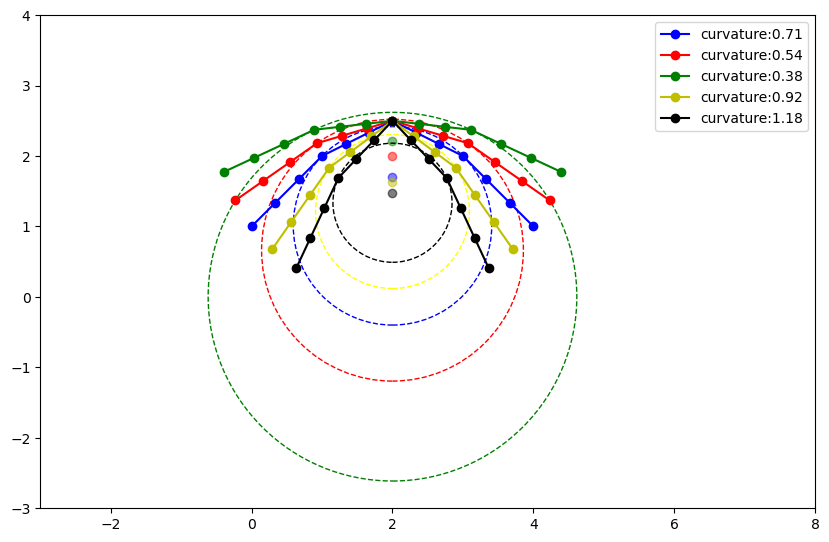

In [18]:
fig, ax = plt.subplots(figsize=(10, 10))
# ax.plot(atom_pos.x, atom_pos.y, 'bo-')
ax.plot(pos0.x, pos0.y, 'bo-', label=f'curvature:{1/r0:.2f}')
ax.plot(pos1.x, pos1.y, 'ro-', label=f'curvature:{1/r1:.2f}')
ax.plot(pos2.x, pos2.y, 'go-', label=f'curvature:{1/r2:.2f}')
ax.plot(pos3.x, pos3.y, 'yo-', label=f'curvature:{1/r3:.2f}')
ax.plot(pos4.x, pos4.y, 'ko-', label=f'curvature:{1/r4:.2f}')
# ax.plot(pos5.x, pos5.y, 'bx-', label=f'curvature:{1/r5:.2f}')
ax.scatter(com.x, com.y, c='b', alpha=0.5)
ax.scatter(com1.x, com1.y, c='r', alpha=0.5)
ax.scatter(com2.x, com2.y, c='g', alpha=0.5)
ax.scatter(com3.x, com3.y, c='y', alpha=0.5)
ax.scatter(com4.x, com4.y, c='k', alpha=0.5)
# ax.scatter(com5.x, com5.y, c='b', alpha=0.5)
ax.set_aspect('equal')
ax.set_xlim(-3, 8)
ax.set_ylim(-3, 4)
circ0 = plt.Circle(c0, r0, color='blue', linestyle='--', fill=False)
circ1 = plt.Circle(c1, r1, color='red', linestyle='--', fill=False)
circ2 = plt.Circle(c2, r2, color='green', linestyle='--', fill=False)
circ3 = plt.Circle(c3, r3, color='yellow', linestyle='--', fill=False)
circ4 = plt.Circle(c4, r4, color='black', linestyle='--', fill=False)
# circ5 = plt.Circle(c5, r5, color='blue', linestyle='--', fill=False)
ax.add_patch(circ0)
ax.add_patch(circ1)
ax.add_patch(circ2)
ax.add_patch(circ3)
ax.add_patch(circ4)
# ax.add_patch(circ5)
# plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.show()

In [29]:
xs0, ys0 = pos0.x[12]-pos0.x[0], pos0.y[7]-pos0.y[0]

In [30]:
for pos, curvature in zip([pos0, pos1, pos2, pos3, pos4], [1/r0, 1/r1, 1/r2, 1/r3, 1/r4]):
    print(curvature, (pos.x[12]-pos.x[0])/xs0, (pos.y[7]-pos.y[0])/ys0)
    write_output(pos, curvature)

0.7101463580511268 1.0 1.0
0.5381789992153192 1.1150438862624057 0.7677475309285452
0.3822116200042116 1.19620772828016 0.5121674416288227
0.9153690517521549 0.8545716197620103 1.201867975095871
1.183167989873526 0.6831775132916569 1.3672177999429942


----
## 2nd&3rd

In [8]:
def bend_cell2(delta_d1, delta_d2, atom_pos, d1, d2):
    x2 = atom_pos['x'].iloc[2]-math.cos(d1-delta_d1)*r2
    y2 = atom_pos['y'].iloc[2]-math.sin(d1-delta_d1)*r2
    x4 = atom_pos['x'].iloc[2]+math.cos(d1-delta_d1)*r2
    y4 = atom_pos['y'].iloc[2]-math.sin(d1-delta_d1)*r2
    x1 = x2-math.cos(d2-delta_d2)*r1
    y1 = y2-math.sin(d2-delta_d2)*r1
    x5 = x4+math.cos(d2-delta_d2)*r1
    y5 = y4-math.sin(d2-delta_d2)*r1
    x3 = atom_pos['x'].iloc[2]
    y3 = atom_pos['y'].iloc[2]

    new_pos = pd.DataFrame({'x': [x1, x2, x3, x4, x5], 'y': [y1, y2, y3, y4, y5]})
    new_pos['z'] = 2.5
    new_pos = interpolate_between_points(new_pos.values, 2)
    new_pos = pd.DataFrame(new_pos, columns=['x', 'y', 'z'])
    com = np.mean(new_pos, axis=0)
    return new_pos, com

In [ ]:
pos1, com1 = bend_cell2(d1/3, d2/3, atom_pos, d1, d2)
pos2, com2 = bend_cell2(d1*2/3, d2*2/3, atom_pos, d1, d2)
pos3, com3 = bend_cell2(d1, d2, atom_pos, d1, d2)
pos4, com4 = bend_cell2(-d1/3, -d2/3, atom_pos, d1, d2)
pos5, com5 = bend_cell2(-d1*2/3, -d2*2/3, atom_pos, d1, d2)
# pos6, com6 = bend_cell2(-d1*3/4, -d2*3/4, atom_pos, d1, d2)
pos0 = interpolate_between_points(atom_pos.values, 2)
pos0 = pd.DataFrame(pos0, columns=['x', 'y', 'z'])
com0 = np.mean(pos0, axis=0)

In [10]:
c0, r0 = find_circle_through_atoms_tangent_to_arms(pos0)
c1, r1 = find_circle_through_atoms_tangent_to_arms(pos1)
c2, r2 = find_circle_through_atoms_tangent_to_arms(pos2)
c3, r3 = find_circle_through_atoms_tangent_to_arms(pos3)
c4, r4 = find_circle_through_atoms_tangent_to_arms(pos4)
c5, r5 = find_circle_through_atoms_tangent_to_arms(pos5)
# print(r0, r1, r2, r3, r4, r5)

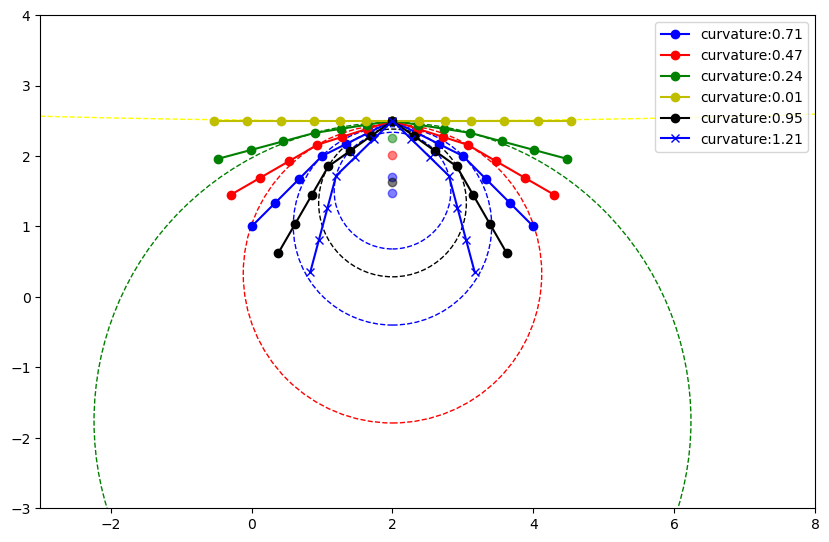

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))
# ax.plot(atom_pos.x, atom_pos.y, 'bo-')
ax.plot(pos0.x, pos0.y, 'bo-', label=f'curvature:{1/r0:.2f}')
ax.plot(pos1.x, pos1.y, 'ro-', label=f'curvature:{1/r1:.2f}')
ax.plot(pos2.x, pos2.y, 'go-', label=f'curvature:{1/r2:.2f}')
ax.plot(pos3.x, pos3.y, 'yo-', label=f'curvature:{1/r3:.2f}')
ax.plot(pos4.x, pos4.y, 'ko-', label=f'curvature:{1/r4:.2f}')
ax.plot(pos5.x, pos5.y, 'bx-', label=f'curvature:{1/r5:.2f}')
ax.scatter(com.x, com.y, c='b', alpha=0.5)
ax.scatter(com1.x, com1.y, c='r', alpha=0.5)
ax.scatter(com2.x, com2.y, c='g', alpha=0.5)
ax.scatter(com3.x, com3.y, c='y', alpha=0.5)
ax.scatter(com4.x, com4.y, c='k', alpha=0.5)
ax.scatter(com5.x, com5.y, c='b', alpha=0.5)
ax.set_aspect('equal')
ax.set_xlim(-3, 8)
ax.set_ylim(-3, 4)
circ0 = plt.Circle(c0, r0, color='blue', linestyle='--', fill=False)
circ1 = plt.Circle(c1, r1, color='red', linestyle='--', fill=False)
circ2 = plt.Circle(c2, r2, color='green', linestyle='--', fill=False)
circ3 = plt.Circle(c3, r3, color='yellow', linestyle='--', fill=False)
circ4 = plt.Circle(c4, r4, color='black', linestyle='--', fill=False)
circ5 = plt.Circle(c5, r5, color='blue', linestyle='--', fill=False)
ax.add_patch(circ0)
ax.add_patch(circ1)
ax.add_patch(circ2)
ax.add_patch(circ3)
ax.add_patch(circ4)
ax.add_patch(circ5)
# plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.show()

In [13]:
xs0, ys0 = pos0.x[12]-pos0.x[0], pos0.y[7]-pos0.y[0]

In [15]:
for pos, curvature in zip([pos0, pos1, pos2, pos3, pos4, pos5], [1/r0, 1/r1, 1/r2, 1/r3, 1/r4, 1/r5]):
    print(curvature, (pos.x[12]-pos.x[0])/xs0, (pos.y[7]-pos.y[0])/ys0)
    write_output(pos, curvature)

0.7101463580511268 1.0 1.0
0.4720785227081793 1.144896620675624 0.7003829965135415
0.2360583346355284 1.2353667863884747 0.3605711611233891
0.005316786231799097 1.266123775561495 0.0
0.9539757311431621 0.8091102300800761 1.2425462551533766
1.2079518647597964 0.5832668392180202 1.4147710554642974
